In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [36]:
data = pd.read_csv("../data/raw/loan_pred.csv")

### Loan Prediction Dataset - Feature Definitions

| Number | Feature Name     | Description                                                          |
|--------|------------------|----------------------------------------------------------------------|
| 1      | Loan_ID          | A unique ID for the loan application.                                |
| 2      | Gender           | Gender of the applicant (Male/Female).                               |
| 3      | Married          | Marital Status of the applicant (Yes/No).                            |
| 4      | Dependents       | It tells whether the applicant has any dependents or not.            |
| 5      | Education        | It will tell us whether the applicant is Graduated or not.           |
| 6      | Self_Employed    | This defines that the applicant is self-employed (Yes/No).           |
| 7      | ApplicantIncome  | Applicant income.                                                    |
| 8      | CoapplicantIncome| Co-applicant income.                                                 |
| 9      | LoanAmount       | Loan amount (in thousands).                                          |
| 10     | Loan_Amount_Term | Terms of loan (in months).                                           |
| 11     | Credit_History   | Credit history of individual's repayment of their debts.             |
| 12     | Property_Area    | Area of property (Rural/Urban/Semi-urban).                           |
| 13     | Loan_Status      | Status of Loan Approved or not (Y- Yes, N-No).                       |

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [38]:
# Check for multiple id's 
multiple_ids = not data["Loan_ID"].nunique() == len(data)
print(f"{multiple_ids=}")

multiple_ids=False


In [39]:
# drop id columns
data.drop(columns=["Loan_ID"], inplace=True)

In [40]:
# Check distribution of categorical and binary variables
def plot_categorical_distribution(df, column, title=None):
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=column, stat="probability", hue="Loan_Status", palette="Set2")
    plt.title(title if title else f'Distribution of {column}')
    plt.xticks(rotation=45)
    plt.savefig("../reports/figures/" + column + "_distribution.png", bbox_inches='tight')

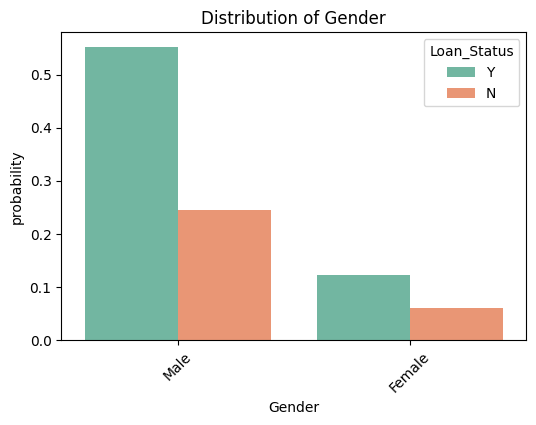

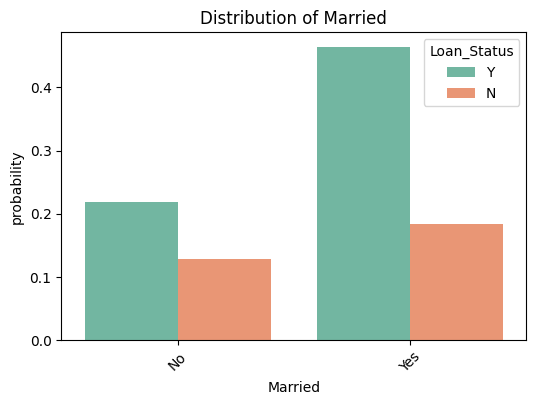

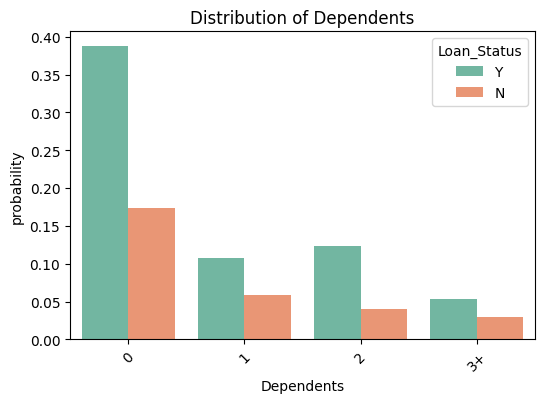

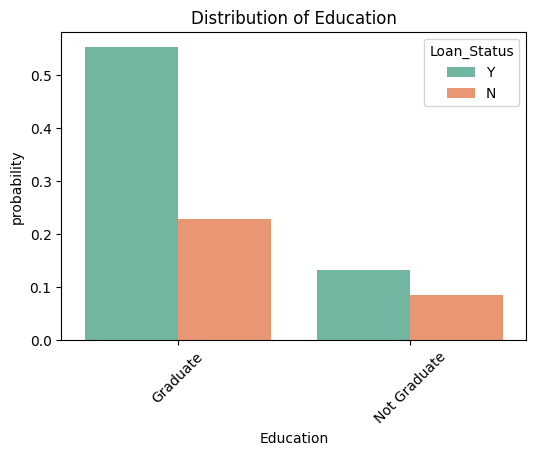

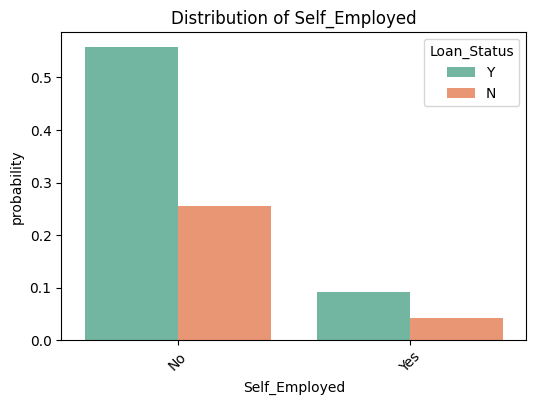

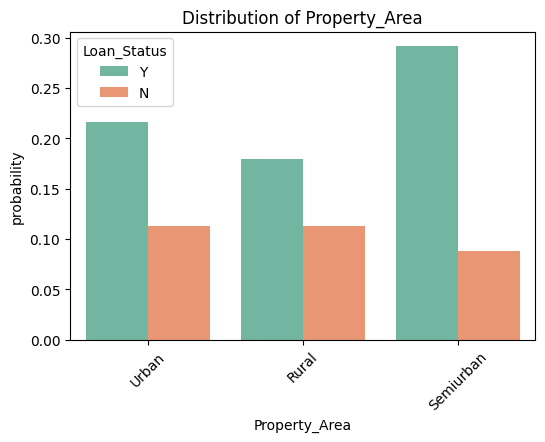

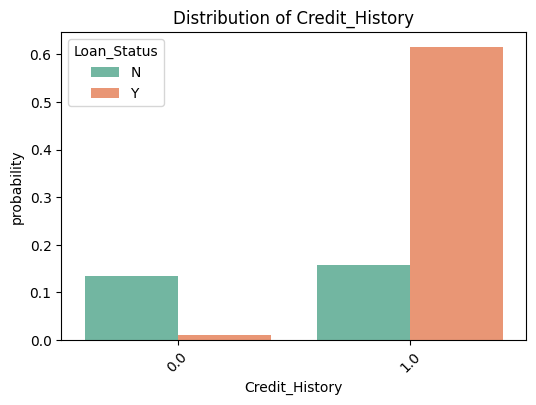

In [41]:
categorical = ["Gender", "Married", "Dependents", "Education", "Self_Employed",
               "Property_Area", "Credit_History"]

for col in categorical:
    _ = plot_categorical_distribution(data, col, title=f'Distribution of {col}')

We can see the feature that matters the most is the Credit_History


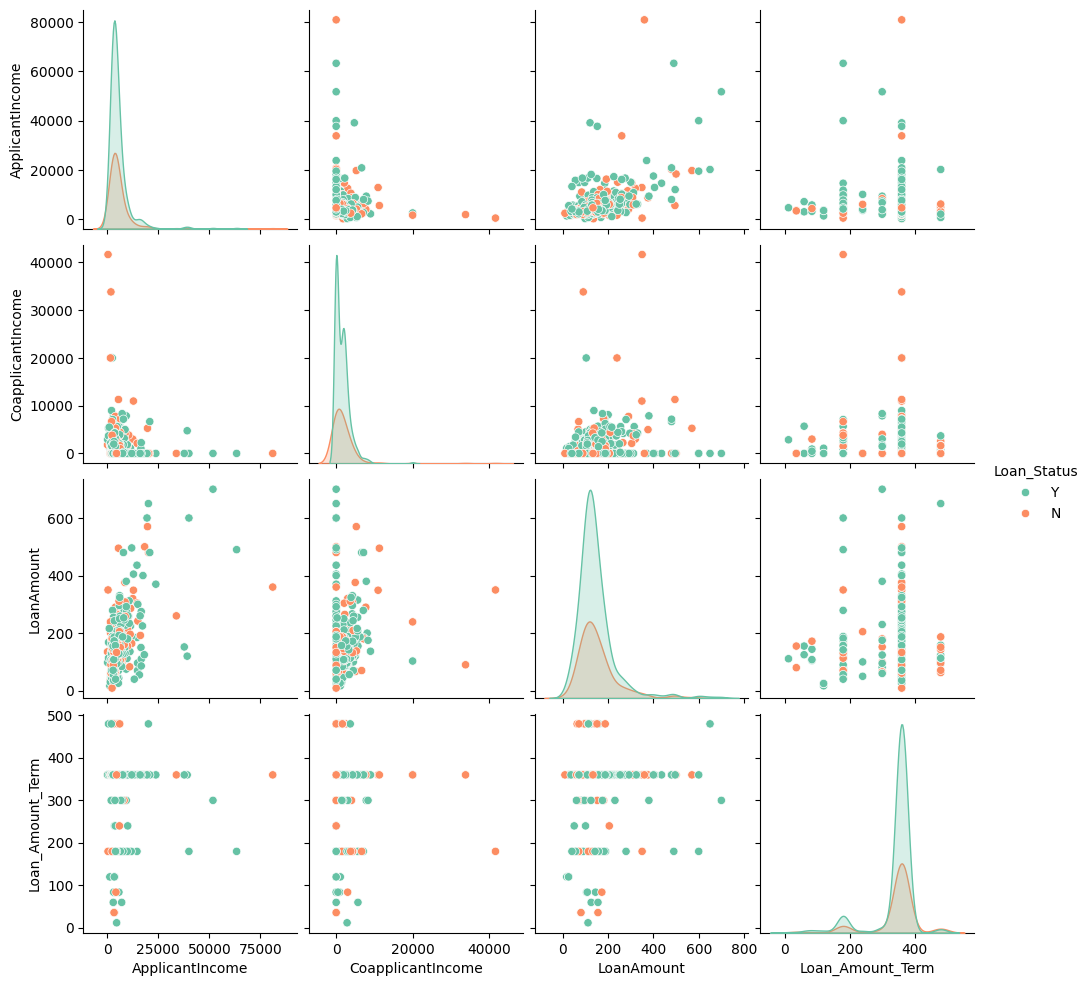

In [42]:
sns.pairplot(data[["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term", "Loan_Status"]],hue="Loan_Status", palette="Set2")

<Axes: title={'center': 'Loan Amount Term Distribution'}, xlabel='Loan_Amount_Term'>

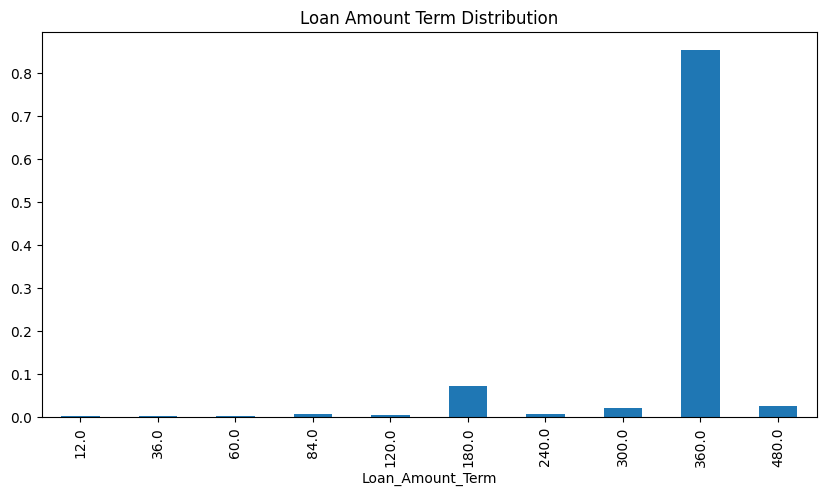

In [43]:
data["Loan_Amount_Term"].value_counts(normalize=True).sort_index().plot(kind="bar", figsize=(10, 5), title="Loan Amount Term Distribution")

### We need to deal with the null values

Although imputation by this simple techniques may lead to biased predictions, we won't care about that right now.

In [53]:
# Check for missing values
data.isna().sum().loc[data.isna().sum() > 0]

Gender              13
Married              3
Dependents          15
Self_Employed       32
LoanAmount          22
Loan_Amount_Term    14
Credit_History      50
dtype: int64

In [12]:
null_ratio = 1 - len(data.dropna())/len(data)
print(f"Null ratio: {null_ratio:.2f}")

Null ratio: 0.22


In [57]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)

# We will use both most_frequent and mean imputation.
mf_imputer = SimpleImputer(strategy="most_frequent")
mean_imputer = SimpleImputer(strategy="mean")

# Then we would also want to encode the categorical variables
ohe = OneHotEncoder(sparse_output=False)

# ordinal encoding for cardinal variables
oe = OrdinalEncoder()

In [55]:
# for target variable
data["Loan_Status"] = data["Loan_Status"].map({"Y": 1, "N": 0})

features = data.drop(columns=["Loan_Status"])
target = data["Loan_Status"]

In [58]:
binary_columns = ["Gender", "Married", "Education",
                  "Self_Employed", "Credit_History"]
cat_columns = ["Property_Area"]
ord_columns = ["Dependents", "Loan_Amount_Term"]
num_columns = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]

In [60]:
bin_pipeline = Pipeline(steps=[
    ("imputer", mf_imputer),
    ("encoder", oe)
])

cat_pipeline = Pipeline(steps=[
    ("imputer", mf_imputer),
    ("encoder", ohe)
])

ord_pipeline = Pipeline(steps=[
    ("imputer", mf_imputer),
    ("encoder", oe)
])

num_pipeline = Pipeline(steps=[
    ("imputer", mean_imputer),
    ("scaler", StandardScaler())
])

In [61]:
preprocessor = ColumnTransformer(
    transformers=[
        ("binary", bin_pipeline, binary_columns),
        ("categorical", cat_pipeline, cat_columns),
        ("ordinal", ord_pipeline, ord_columns),
        ("numerical", num_pipeline, num_columns)
    ],
    remainder="drop"
)

In [65]:
pp_features = preprocessor.fit_transform(features)

In [66]:
preprocessor.transformers_

[('binary',
  Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                  ('encoder', OrdinalEncoder())]),
  ['Gender', 'Married', 'Education', 'Self_Employed', 'Credit_History']),
 ('categorical',
  Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                  ('encoder', OneHotEncoder(sparse_output=False))]),
  ['Property_Area']),
 ('ordinal',
  Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                  ('encoder', OrdinalEncoder())]),
  ['Dependents', 'Loan_Amount_Term']),
 ('numerical',
  Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())]),
  ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'])]